## Image classification model with very little data
from this [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) 

In [2]:
import glob
import numpy as np
import cv2
import matplotlib

%matplotlib inline

In [1]:
from keras.preprocessing import image as image_utils #????
# from imagenet_utils import decode_predictions
# from imagenet_utils import preprocess_input

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


Objectives:
- train small network from scratch (as baseline)
- use bottleneck features of pre-trained network
- fine-tune top layers of pre-trained network

Keras features to cover:
- `fit_generator` (for training model using python data generators)
- `ImageDataGenerator` (for real-time data augmentation)
- layer freezing and model fine-tuning

Setup:
- Keras, SciPy, PIL installed
- NVIDIA GPU (with cuDNN installed) is nice (but not neccessary on small image set)
- training + validation data directories with one subdirectly per image class (png or jpg)

Deep learning on small-data problems:
- deep learning requires learning features automatically from data, generally only possible when lots of training data is available esp where input samples are very high-dimensional like images
- but convolutional neural networks one of best models for "perceptual problems" such as image classification even with little data to learn from
- training convnets from scrath on small image dataset will still yield reasonable results
- deep learning models are highly repurposable - you can take an image classification trained on large-scale data then reuse it on significantly different problem
- many pre-trained models (usually trained on ImageNet dataset) can be use to bootstrap powerful vision models out of very little data 

In [4]:
# dimensions of our images.
img_width, img_height = 150, 150

In [5]:
#path to images
train_data_dir = '/Users/VanessaG/Desktop/pizza_class_data/train/'
validation_data_dir = '/Users/VanessaG/Desktop/pizza_class_data/validation'

#model paramter setup
nb_train_samples = 2000
nb_validation_samples = 800
nb_epoch = 50

In [9]:
#instantiate moel
model = Sequential()

### stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers

dim_ordering: One of {"th", "tf"}. "tf" mode means that the images should have shape (samples, width, height, channels), "th" mode means that the images should have shape (samples, channels, width, height). It defaults to the image_dim_ordering value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "tf".

In [10]:
# Because you're using tensorflow you have to put the "depth" as the 3rd dimension.
# Apparently for theano the depth comes first like in tutorial (3, 150, 150)
# and in tensorflow it comes last like (150, 150, 3)
model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [11]:
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [12]:
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

### plus two fully-connected layers
We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification.

In [13]:
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

In [14]:
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### prepare data
use .flow_from_directory() to generate batches of image data (and their labels) directly from our jpgs in their respective folders.

### rescale
- value by which you mulitply the data before any other processing
- original image RGB coefficients 0-255 but these values are too high for our models to process (given a typical learning rate) so target values between 0-1 by scalling with a 1/255 factor

In [16]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [17]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [22]:
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 800 images belonging to 2 classes.


In [23]:
# validation_generator = test_datagen.flow_from_directory(
#         validation_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=1,
#         #save_to_dir='val_aug'
#         class_mode='binary',
#         shuffle=False)

In [24]:
# pizzas = glob.glob(validation_data_dir+'/pizza/*.jpg')
# not_pizzas = glob.glob(validation_data_dir+'/not_pizza/*.jpg')
# print len(pizzas), len(not_pizzas)

In [25]:
# predictions = []
# predicted_labels = []
# for i, (img, y) in enumerate(validation_generator):
#     pp = model.predict(img)
#     label = int(pp[0] >= 0.5)
#     predictions.append(pp[0][0])
#     predicted_labels.append(label)
#     if i >= 800:
#         break

In [26]:
# print predictions[0:10]
# print predicted_labels[0:10]

In [27]:
# np.mean([1 if pl == l 
#          else 0 for pl, l 
#          in zip(predicted_labels, np.zeros(400).tolist()+np.ones(400).tolist())])

In [28]:
# image_file_predictions = {}
# for i, filename in enumerate(not_pizzas+pizzas):
#     image_file_predictions[filename] = {
#         'predicted_class':predicted_labels[i],
#         'predicted_prob_pizza':predictions[i]
#     }

In [29]:
# image_file_df = pd.DataFrame(image_file_predictions)

In [30]:
# image_file_df.T.head()

### use these generators to train model
Fits the model on data generated batch-by-batch by a Python generator. The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.



In [31]:
pizza_model = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

Epoch 1/50
2000/2000 [==============================] - 79s - loss: 0.6744 - acc: 0.5965 - val_loss: 0.6215 - val_acc: 0.6525
Epoch 2/50
2000/2000 [==============================] - 73s - loss: 0.6228 - acc: 0.6775 - val_loss: 0.5397 - val_acc: 0.7238
Epoch 3/50
2000/2000 [==============================] - 73s - loss: 0.5900 - acc: 0.7110 - val_loss: 0.5350 - val_acc: 0.7712
Epoch 4/50
2000/2000 [==============================] - 73s - loss: 0.5570 - acc: 0.7390 - val_loss: 0.5325 - val_acc: 0.7350
Epoch 5/50
2000/2000 [==============================] - 74s - loss: 0.5414 - acc: 0.7410 - val_loss: 0.7256 - val_acc: 0.5625
Epoch 6/50
2000/2000 [==============================] - 73s - loss: 0.5407 - acc: 0.7380 - val_loss: 0.5973 - val_acc: 0.6713
Epoch 7/50
2000/2000 [==============================] - 74s - loss: 0.5136 - acc: 0.7615 - val_loss: 0.4852 - val_acc: 0.7750
Epoch 8/50
2000/2000 [==============================] - 74s - loss: 0.5182 - acc: 0.7495 - val_loss: 0.4416 - val_acc:

In [32]:
model.save_weights('/Users/VanessaG/Desktop/DSI-SF-2-vnessified/capstone/keras_pizza_model.h5')

In [40]:
pizza_model.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

In [45]:
np.mean(pizza_model.history['acc'])

0.80617000000000005

In [38]:
predictions = model.predict_generator(validation_generator, nb_validation_samples,
                                      max_q_size=10, nb_worker=1, pickle_safe=False)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123f19ed0>]], dtype=object)

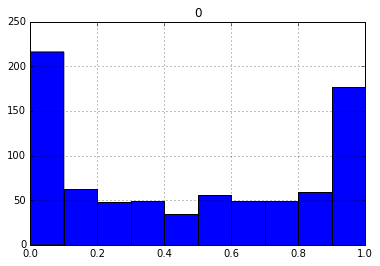

In [67]:
import pandas as pd
%matplotlib inline
preds = pd.DataFrame(predictions)
preds.hist()

In [62]:
model.evaluate_generator(validation_generator, nb_validation_samples, max_q_size=10,
                         nb_worker=1)

[0.37268579304218291, 0.85250000000000004]

In [68]:
validation_generator.class_indices

{'not_pizza': 0, 'pizza': 1}

In [74]:
predictions[0:10]

array([[ 0.99488431],
       [ 0.01543689],
       [ 0.08674085],
       [ 0.31872407],
       [ 0.16791809],
       [ 0.15143231],
       [ 0.00232882],
       [ 0.24438238],
       [ 0.33933592],
       [ 0.09753565]], dtype=float32)

In [79]:
tmp = validation_generator.next()

In [83]:
tmp[1]

array([ 1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  1.,  0.,  1.,  1.,  0.], dtype=float32)

In [85]:
model.predict(tmp[0])

array([[ 0.08126235],
       [ 0.57426715],
       [ 0.49691847],
       [ 0.04579484],
       [ 0.94406939],
       [ 0.07271674],
       [ 0.99968314],
       [ 0.18125772],
       [ 0.93656653],
       [ 0.02479019],
       [ 0.35465115],
       [ 0.22954753],
       [ 0.63639081],
       [ 0.43296358],
       [ 0.9122054 ],
       [ 0.04420486],
       [ 0.56888866],
       [ 0.97104329],
       [ 0.35707584],
       [ 0.52468878],
       [ 0.27928662],
       [ 0.34185609],
       [ 0.02060525],
       [ 0.16323878],
       [ 0.05697659],
       [ 0.04494169],
       [ 0.01118162],
       [ 0.2705709 ],
       [ 0.00876822],
       [ 0.93954331],
       [ 0.97481751],
       [ 0.01143311]], dtype=float32)

In [75]:
predicted_labels = [1 if p[0] > 0.5 else 0 for p in predictions]


In [78]:
predicted_labels[0:10]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [77]:
np.mean(validation_generator.classes == predicted_labels)

0.48749999999999999

In [61]:
predicted_classes = []
for i, img_batch in enumerate(validation_generator):
    print i
    for img in img_batch:
        predicted_classes.append(model.predict_classes(img))

0
32/32 [==============================] - 0s


Exception: Error when checking : expected convolution2d_input_3 to have 4 dimensions, but got array with shape (32, 1)

In [60]:
type(tmp[0])

numpy.ndarray